<a href="https://colab.research.google.com/github/Matig91/Colab-projects/blob/main/2_svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'

FOLDERNAME = 'cs231n/assignments/assignment1/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.

import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.

%cd /content/drive/My Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My Drive/$FOLDERNAME

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/cs231n/assignments/assignment1/cs231n/datasets
/content/drive/My Drive/cs231n/assignments/assignment1


# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet
(including its outputs and any supporting code outside of the worksheet)
with your assignment submission.
For more details see the
[assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression
for its **analytic gradient**
- **check your implementation**
using numerical gradient
- use a validation set
to **tune the learning rate
and regularization** strength
- **optimize** the loss function
with **SGD**
- **visualize** the final
learned weights


In [ ]:
# Run some setup code for this notebook.
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [ ]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

In [ ]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [ ]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set

mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

In [ ]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

In [ ]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data

mean_image = np.mean(X_train, axis=0)
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8'))
# visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [ ]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val   = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test  = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev   = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## SVM Classifier

Your code for this section will all be written inside `cs231n/classifiers/linear_svm.py`.

As you can see, we have prefilled the function `svm_loss_naive` which uses for loops to evaluate the multiclass SVM loss function.

In [ ]:
# @title x UTILS - linear_svm (OLD BackUP)

# from builtins import range
# import numpy as np
# from random import shuffle
# from past.builtins import xrange

# def svm_loss_naive(W, X, y, reg):
#     """
#     Structured SVM loss function, naive implementation (with loops).
#     Inputs have dimension D, there are C classes, and we operate on minibatches
#     of N examples.
#     Inputs:
#     - W: A numpy array of shape (D, C) containing weights.
#     - X: A numpy array of shape (N, D) containing a minibatch of data.
#     - y: A numpy array of shape (N,) containing training labels; y[i] = c means
#       that X[i] has label c, where 0 <= c < C.
#     - reg: (float) regularization strength
#     Returns a tuple of:
#     - loss as single float
#     - gradient with respect to weights W; an array of same shape as W
#     """
#     dW = np.zeros(W.shape)  # initialize the gradient as zero

#     # compute the loss and the gradient
#     num_classes = W.shape[1]
#     num_train   = X.shape[0]
#     loss = 0.0
#     # binary = np.zeros([num_train, num_classes])
#     for i in range(num_train):
#         scores = X[i].dot(W)
#         correct_class_score = scores[y[i]]
#         margin = np.zeros_like(scores)
#         for j in range(num_classes):
#             if j == y[i]:
#                 continue
#             margin = scores[j] - correct_class_score + 1  # note delta = 1
#             if margin > 0:
#                 loss += margin     # FP
#                 # print(margin)
#                 dW[:, j]    += X[i] # BP
#                 dW[:, y[i]] -= X[i] # BP
#     # Right now the loss is a sum over all training examples, but we want it
#     # to be an average instead so we divide by num_train.
#     loss /= num_train
#     # loss += reg * np.sum(W * W) # Add regularization to the loss.

#     dW /= num_train  # scale gradient ovr the number of samples
#     dW += 2*reg*W    # append partial derivative of regularization term
#     return loss, dW

# def svm_loss_vectorized(W, X, y, reg):
#     """
#     Structured SVM loss function,
#     vectorized implementation.
#     Inputs and outputs are the same as svm_loss_naive.
#     """
#     loss = 0.0
#     dW = np.zeros_like(W)

#     N = len(y)
#     scores = X.dot(W)
#     # N x D | D x C --> N x C
#     correct_scores_n = scores[range(N), y].reshape(N, 1)
#     # Broadcasting !!!
#     margins = scores - correct_scores_n + 1
#     margins[range(N), y] = 0
#     loss    = np.sum((margins > 0)*margins) / N  + reg * np.sum(W*W)
#     # print(margins)

#     # + reg * np.sum(W*W)

#     dW              = (margins > 0).astype(int)

#   # dW[range(N), y] = -np.sum(dW, axis = 1) + 1

#     dW[range(N), y] = -np.sum( dW, axis = 1 )
#     # boolean (condition test) into integer (0 vs 1)
#     dW      = X.T.dot(dW) / N  + 2*reg * np.sum(W)  # D x C <-- D x N | N x C

#     return loss, dW


In [ ]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive, svm_loss_vectorized
import time

np.random.seed(12)

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

In [ ]:
np.random.seed(12)
W = np.random.randn(3073, 10) * 0.0001

loss, grad = svm_loss_vectorized(W, X_dev, y_dev, 0.001)
# loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.001)
# loss, grad = svm_loss_vectorized2(W, X_dev, y_dev, 0.001)
loss, grad, loss.shape, grad.shape,

The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [ ]:
from cs231n.gradient_check import grad_check_sparse
"""Once you've implemented the gradient, recompute it with the code below
and gradient check it with the function we provided for you
Compute the loss and its gradient at W """

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.

f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

**Inline Question 1**

It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*

$\color{blue}{\textit Your Answer:}$ *fill this in.*  


In [ ]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized

tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

In [ ]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.
# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.

tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.

difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss. Your code for this part will be written inside `cs231n/classifiers/linear_classifier.py`.

In [ ]:
# @title
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM

svm = LinearSVM()

tic = time.time()

loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)

toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 795.370341
iteration 100 / 1500: loss 289.151507
iteration 200 / 1500: loss 108.598168
iteration 300 / 1500: loss 43.125295
iteration 400 / 1500: loss 18.933595
iteration 500 / 1500: loss 9.913285
iteration 600 / 1500: loss 7.147289
iteration 700 / 1500: loss 5.901102
iteration 800 / 1500: loss 6.178147
iteration 900 / 1500: loss 5.403996
iteration 1000 / 1500: loss 5.557556
iteration 1100 / 1500: loss 4.995563
iteration 1200 / 1500: loss 5.467042
iteration 1300 / 1500: loss 5.128573
iteration 1400 / 1500: loss 5.389986
That took 9.174339s


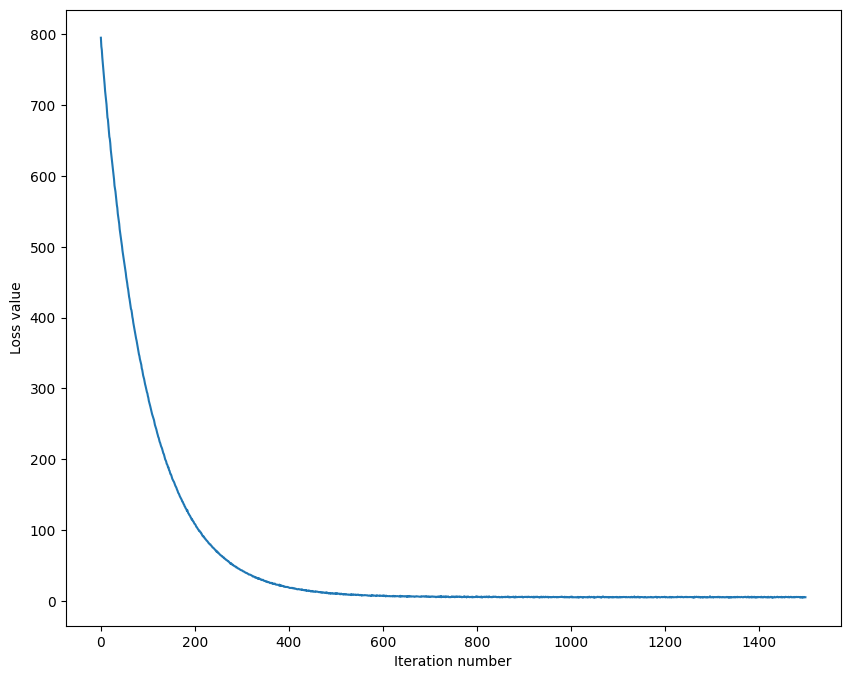

In [ ]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [ ]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.371469
validation accuracy: 0.378000


In [ ]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.39 (> 0.385) on the validation set.

# Note: you may see runtime/overflow warnings during hyper-parameter search.
# This may be caused by extreme values, and is not a bug.

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.

results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates           = [1e-7, 5e-5, 0.000000244949, 0.0000002710806]
regularization_strengths = [2.5e4, 5e4, 5000, 15811.39, 8891.397]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

from cs231n.classifiers import LinearSVM
for lr in learning_rates:
  for reg in regularization_strengths:

    svm = LinearSVM()
    training = svm.train(X_train, y_train, learning_rate=lr, reg=reg,
                      num_iters=1000)

    y_train_pred, y_val_pred = svm.predict(X_train), svm.predict(X_val)

    results[(lr, reg)] = np.mean(y_train == y_train_pred), np.mean(y_val == y_val_pred)

    if results[(lr, reg)][1] > best_val:
      best_val = results[(lr, reg)][1]
      best_svm = svm                      # The LinearSVM object that achieved the highest validation rate.

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-07 reg 5.000000e+03 train accuracy: 0.338388 val accuracy: 0.345000
lr 1.000000e-07 reg 8.891397e+03 train accuracy: 0.371449 val accuracy: 0.375000
lr 1.000000e-07 reg 1.581139e+04 train accuracy: 0.374000 val accuracy: 0.369000
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.369367 val accuracy: 0.382000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.361980 val accuracy: 0.386000
lr 2.449490e-07 reg 5.000000e+03 train accuracy: 0.389061 val accuracy: 0.389000
lr 2.449490e-07 reg 8.891397e+03 train accuracy: 0.377347 val accuracy: 0.379000
lr 2.449490e-07 reg 1.581139e+04 train accuracy: 0.365673 val accuracy: 0.374000
lr 2.449490e-07 reg 2.500000e+04 train accuracy: 0.358612 val accuracy: 0.362000
lr 2.449490e-07 reg 5.000000e+04 train accuracy: 0.342082 val accuracy: 0.354000
lr 2.710806e-07 reg 5.000000e+03 train accuracy: 0.388061 val accuracy: 0.381000
lr 2.710806e-07 reg 8.891397e+03 train accuracy: 0.378000 val accuracy: 0.385000
lr 2.710806e-07 reg 1.581139

In [ ]:
# @title 2nd Option

import itertools

for lr, reg in itertools.product(learning_rates, regularization_strengths):
  svm = LinearSVM()
  training = svm.train(X_train, y_train, learning_rate=lr, reg=reg,
                    num_iters=1000)

  y_train_pred, y_val_pred = svm.predict(X_train), svm.predict(X_val)

  results[(lr, reg)] = np.mean(y_train == y_train_pred), np.mean(y_val == y_val_pred)

  if results[(lr, reg)][1] > best_val:
    best_val = results[(lr, reg)][1]
    best_svm = svm                      # The LinearSVM object that achieved the highest validation rate.

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved during cross-validation: %f' % best_val)


/content/drive/My Drive/cs231n/assignments/assignment1/cs231n/classifiers/linear_svm.py:92: RuntimeWarning: overflow encountered in scalar multiply
  loss        = np.sum(margins)/N + reg * np.sum(W**2)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/content/drive/My Drive/cs231n/assignments/assignment1/cs231n/classifiers/linear_svm.py:92: RuntimeWarning: overflow encountered in square
  loss        = np.sum(margins)/N + reg * np.sum(W**2)
/content/drive/My Drive/cs231n/assignments/assignment1/cs231n/classifiers/linear_svm.py:114: RuntimeWarning: overflow encountered in multiply
  dW           = X.T @ margins_grad / N + 2*reg*W  # D x C = D x N | N x C
/content/drive/My Drive/cs231n/assignments/assignment1/cs231n/classifiers/linear_svm.py:88: RuntimeWarning: invalid value encountered in matmul
  scores      = X @ W
/content/drive/My Drive/cs231n/assignments/a

lr 1.000000e-07 reg 5.000000e+03 train accuracy: 0.334612 val accuracy: 0.342000
lr 1.000000e-07 reg 8.891397e+03 train accuracy: 0.372143 val accuracy: 0.365000
lr 1.000000e-07 reg 1.581139e+04 train accuracy: 0.377041 val accuracy: 0.373000
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.367184 val accuracy: 0.373000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.358714 val accuracy: 0.373000
lr 2.449490e-07 reg 5.000000e+03 train accuracy: 0.384735 val accuracy: 0.397000
lr 2.449490e-07 reg 8.891397e+03 train accuracy: 0.379306 val accuracy: 0.369000
lr 2.449490e-07 reg 1.581139e+04 train accuracy: 0.368653 val accuracy: 0.379000
lr 2.449490e-07 reg 2.500000e+04 train accuracy: 0.350388 val accuracy: 0.346000
lr 2.449490e-07 reg 5.000000e+04 train accuracy: 0.335633 val accuracy: 0.348000
lr 2.710806e-07 reg 5.000000e+03 train accuracy: 0.384408 val accuracy: 0.393000
lr 2.710806e-07 reg 8.891397e+03 train accuracy: 0.372837 val accuracy: 0.367000
lr 2.710806e-07 reg 1.581139

In [ ]:
grid_search = [ (lr, reg) for lr in learning_rates for reg in regularization_strengths ]

for lr, reg in grid_search:
  svm = LinearSVM()
  training = svm.train(X_train, y_train, learning_rate=lr, reg=reg,
                    num_iters=1000)

  y_train_pred, y_val_pred = svm.predict(X_train), svm.predict(X_val)

  results[(lr, reg)] = np.mean(y_train == y_train_pred), np.mean(y_val == y_val_pred)

  if results[(lr, reg)][1] > best_val:
    best_val = results[(lr, reg)][1]
    best_svm = svm                      # The LinearSVM object that achieved the highest validation rate.

for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved during cross-validation: %f' % best_val)

/content/drive/My Drive/cs231n/assignments/assignment1/cs231n/classifiers/linear_svm.py:92: RuntimeWarning: overflow encountered in scalar multiply
  loss        = np.sum(margins)/N + reg * np.sum(W**2)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/content/drive/My Drive/cs231n/assignments/assignment1/cs231n/classifiers/linear_svm.py:92: RuntimeWarning: overflow encountered in square
  loss        = np.sum(margins)/N + reg * np.sum(W**2)
/content/drive/My Drive/cs231n/assignments/assignment1/cs231n/classifiers/linear_svm.py:114: RuntimeWarning: overflow encountered in multiply
  dW           = X.T @ margins_grad / N + 2*reg*W  # D x C = D x N | N x C
/content/drive/My Drive/cs231n/assignments/assignment1/cs231n/classifiers/linear_svm.py:88: RuntimeWarning: invalid value encountered in matmul
  scores      = X @ W
/content/drive/My Drive/cs231n/assignments/a

lr 1.000000e-07 reg 5.000000e+03 train accuracy: 0.343510 val accuracy: 0.360000
lr 1.000000e-07 reg 8.891397e+03 train accuracy: 0.372245 val accuracy: 0.376000
lr 1.000000e-07 reg 1.581139e+04 train accuracy: 0.371510 val accuracy: 0.378000
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.371653 val accuracy: 0.379000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.355592 val accuracy: 0.366000
lr 2.449490e-07 reg 5.000000e+03 train accuracy: 0.381143 val accuracy: 0.388000
lr 2.449490e-07 reg 8.891397e+03 train accuracy: 0.372898 val accuracy: 0.377000
lr 2.449490e-07 reg 1.581139e+04 train accuracy: 0.360306 val accuracy: 0.382000
lr 2.449490e-07 reg 2.500000e+04 train accuracy: 0.350898 val accuracy: 0.359000
lr 2.449490e-07 reg 5.000000e+04 train accuracy: 0.330429 val accuracy: 0.329000
lr 2.710806e-07 reg 5.000000e+03 train accuracy: 0.382061 val accuracy: 0.374000
lr 2.710806e-07 reg 8.891397e+03 train accuracy: 0.372184 val accuracy: 0.373000
lr 2.710806e-07 reg 1.581139

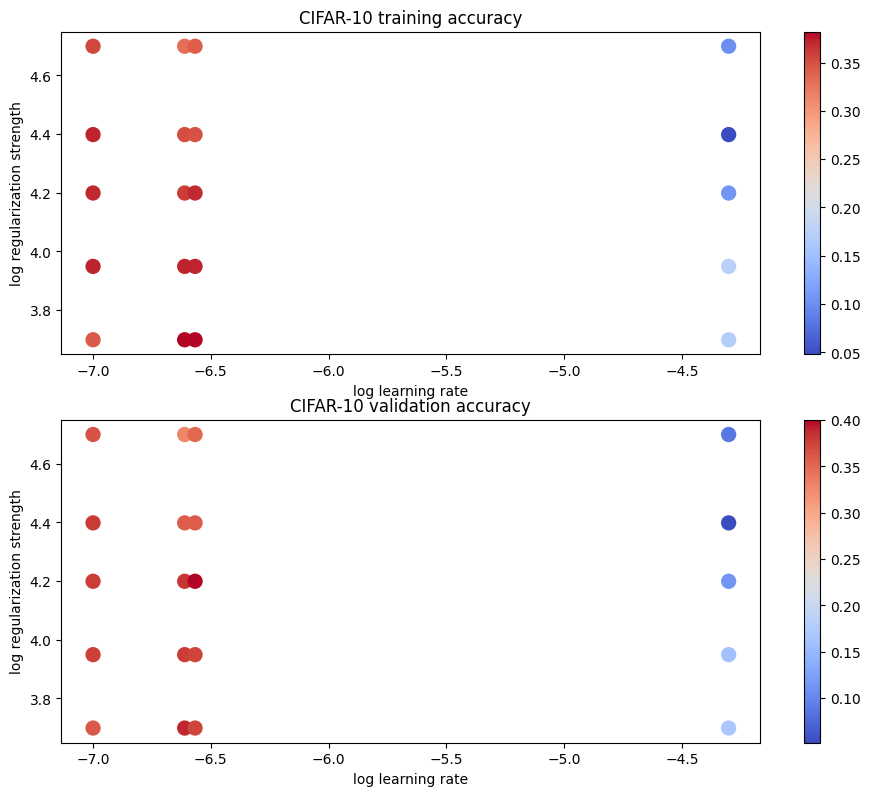

In [ ]:
# Visualize the cross-validation results
import math
import pdb

# pdb.set_trace()

x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.tight_layout(pad=3)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [ ]:
# Evaluate the best svm on test set

y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.363000


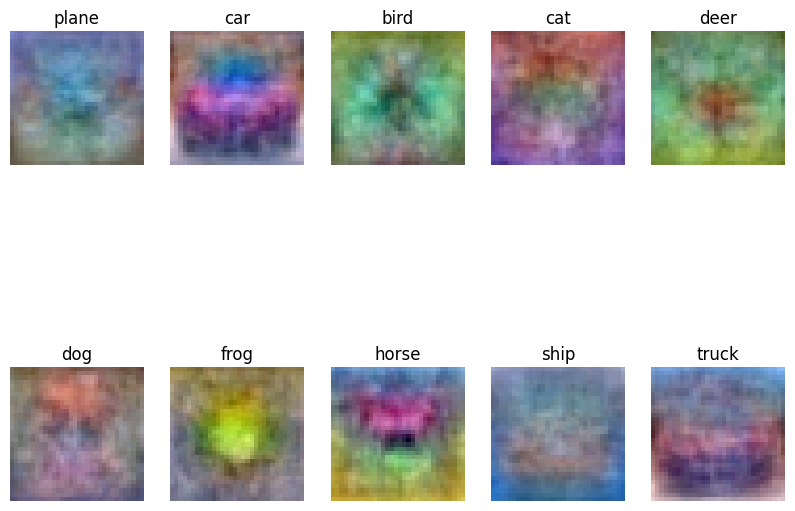

In [ ]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

**Inline question 2**

Describe what your visualized SVM weights look like, and offer a brief explanation for why they look the way they do.

$\color{blue}{\textit Your Answer:}$ *fill this in*  
